<a href="https://colab.research.google.com/github/chuancao26/islp/blob/main/LabNonLinearApproach.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install ISLP

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 16.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 349.3/349.3 kB 10.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.6/84.6 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 849.5/849.5 kB 10.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.2/983.2 kB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.3/117.3 kB 3.5 MB/s eta 0:00:00
  Created wheel for autograd-gamma: filename=autograd_gamma-0.5.0-py3-none-any.whl size=4030 sha256=05144d873827d1119302338d5146f4bc8920553b66b4ebf299f6bd0ffad297c0
  Stored in directory: /root/.cache/pip/wheels/50/37/21/0a719b9d89c635e89ff24bd93b862882ad675279552013b2fb
Successfully built autograd-gamma


imports iniciales

In [2]:
import numpy as np, pandas as pd
import matplotlib.pyplot as plt, seaborn as sns
import statsmodels.api as sm

from ISLP import load_data
from ISLP.models import (summarize,
                        poly,
                        ModelSpec as MS)
from statsmodels.stats.anova import anova_lm

New imports

In [3]:
from pygam import (s as s_gam,
                   l as l_gam,
                   f as f_gam,
                   LinearGAM,
                   LogisticGAM)
from ISLP.transforms import (BSpline,
                             NaturalSpline)
from ISLP.models import bs, ns
from ISLP.pygam import (approx_lam,
                        degrees_of_freedom,
                        plot as plot_gam,
                        anova as anova_gam)

# Polynomial regression and Step Functions

In [ ]:
# cargando la data
df = load_data('Wage')
y = df["wage"]
age = df["age"]


In [ ]:
# vamos a fittear una 4-d polinomial regression.
poly_age = MS([poly("age", degree=4)]).fit(df)
M = sm.OLS(y, poly_age.transform(df)).fit()
summarize(M)

,coef,std err,t,P>|t|
intercept,111.7036,0.729,153.283,0.000
"poly(age, degree=4)[0]",447.0679,39.915,11.201,0.000
"poly(age, degree=4)[1]",-478.3158,39.915,-11.983,0.000
"poly(age, degree=4)[2]",125.5217,39.915,3.145,0.002
"poly(age, degree=4)[3]",-77.9112,39.915,-1.952,0.051


In [ ]:
age_grid = np.linspace(age.min(), age.max(), 100)
age_df = pd.DataFrame({"age": age_grid})

Generador de graficos con una basis transformation

In [35]:
def plot_wage_fit(age_df,
                  basis,
                  title):
  X = basis.transform(df)
  Xnew = basis.transform(age_df)
  M = sm.OLS(y, X).fit()
  preds = M.get_prediction(Xnew)
  bands = preds.conf_int(alpha=0.05)
  fig, ax = plt.subplots(figsize=(8,8))
  ax.scatter(age, y,
             facecolor="gray",
             alpha=.5)
  for val, ls in zip([preds.predicted_mean, bands[:, 0], bands[:, 1]],
                      ["b", "r--", "r--"]):
    ax.plot(age_df.values, val, ls, linewidth=2)
  ax.set_title(title, fontsize=20)
  ax.set_xlabel("Age", fontsize=20)
  ax.set_ylabel("Wage", fontsize=20)
  return ax

<Axes: title={'center': 'Degree-4 polynomial'}, xlabel='Age', ylabel='Wage'>

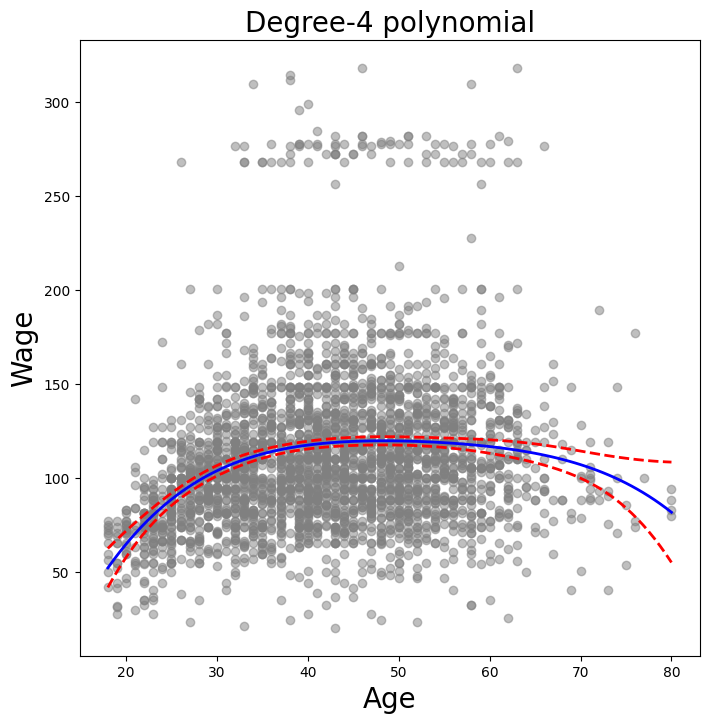

In [ ]:
plot_wage_fit(age_df,
              poly_age,
              "Degree-4 polynomial")

In [ ]:
 # veamos un grafico con diferentes degrees polynomial
models = [MS([poly("age", degree=d)]) for d in range(1, 6)]
Xs = [model.fit_transform(df) for model in models]
anova_lm(*[sm.OLS(y, X_).fit() for X_ in Xs])

,df_resid,ssr,df_diff,ss_diff,F,Pr(>F)
0,2998.0,5.022216e+06,0.0,NaN,NaN,NaN
1,2997.0,4.793430e+06,1.0,228786.010128,143.593107,2.363850e-32
2,2996.0,4.777674e+06,1.0,15755.693664,9.888756,1.679202e-03
3,2995.0,4.771604e+06,1.0,6070.152124,3.809813,5.104620e-02
4,2994.0,4.770322e+06,1.0,1282.563017,0.804976,3.696820e-01


In [ ]:
summarize(M)

,coef,std err,t,P>|t|
intercept,111.7036,0.729,153.283,0.000
"poly(age, degree=4)[0]",447.0679,39.915,11.201,0.000
"poly(age, degree=4)[1]",-478.3158,39.915,-11.983,0.000
"poly(age, degree=4)[2]",125.5217,39.915,3.145,0.002
"poly(age, degree=4)[3]",-77.9112,39.915,-1.952,0.051


Ahora veamos el caso de una regresion Logistica

In [ ]:
X = poly_age.transform(df)
high_earn = df["high_earn"] = y < 250

glm = sm.GLM(high_earn,
             X,
               family=sm.families.Binomial())
B = glm.fit()
summarize(B)


,coef,std err,z,P>|z|
intercept,4.3012,0.345,12.457,0.000
"poly(age, degree=4)[0]",-71.9642,26.133,-2.754,0.006
"poly(age, degree=4)[1]",85.7729,35.929,2.387,0.017
"poly(age, degree=4)[2]",-34.1626,19.697,-1.734,0.083
"poly(age, degree=4)[3]",47.4008,24.105,1.966,0.049


In [ ]:
newX = poly_age.transform(age_df)
preds = B.get_prediction(newX)
bands = preds.conf_int(alpha=0.05)

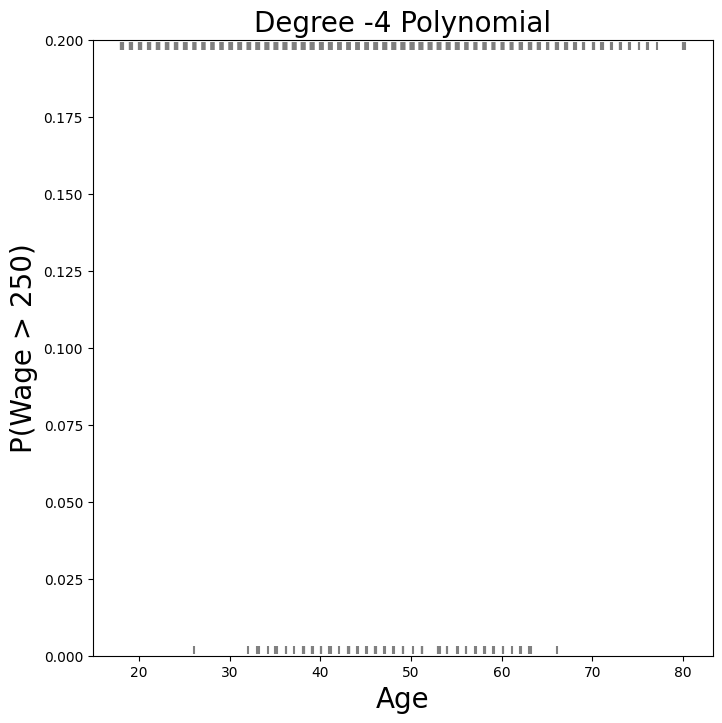

In [ ]:
fig, ax = plt.subplots(figsize=(8,8))
rng = np.random.default_rng(0)
ax.scatter(age +
           0.2 * rng.uniform(size=y.shape[0]),
           np.where(high_earn, 0.198, 0.002),
           fc='gray',
           marker='|')
for val, ls in zip([preds.predicted_mean ,
                    bands[:,0],
                    bands[:,1]],
                     ['b','r--','r--']):
  ax.plot(age_df.values, val, ls, linewidth=2)
ax.set_title('Degree -4 Polynomial', fontsize=20)
ax.set_xlabel('Age', fontsize=20)
ax.set_ylim([0,0.2])
ax.set_ylabel('P(Wage > 250)', fontsize=20);

## Step Function (faltan graficos)

Vamos a ver el caso de pd.qcut para categorizar la variable age

In [ ]:
cut_age = pd.qcut(age, 4)
summarize(sm.OLS(y, pd.get_dummies(cut_age)).fit())

,coef,std err,t,P>|t|
"(17.999, 33.75]",94.1584,1.478,63.692,0.0
"(33.75, 42.0]",116.6608,1.470,79.385,0.0
"(42.0, 51.0]",119.1887,1.416,84.147,0.0
"(51.0, 80.0]",116.5717,1.559,74.751,0.0


# Splines

In [ ]:
bs_ = BSpline(internal_knots=[25,40,60], intercept=True).fit(age)
bs_age = bs_.transform(age)
bs_age.shape

(3000, 7)

Tambien podemos hacerlo usando el MS

In [ ]:
bs_age = MS([bs("age", internal_knots=[25,40,60],
                name="bs(age)")]).fit(df)
Xbs = bs_age.transform(df)
M = sm.OLS(y, Xbs).fit()
summarize(M)

,coef,std err,t,P>|t|
intercept,60.4937,9.460,6.394,0.000
bs(age)[0],3.9805,12.538,0.317,0.751
bs(age)[1],44.6310,9.626,4.636,0.000
bs(age)[2],62.8388,10.755,5.843,0.000
bs(age)[3],55.9908,10.706,5.230,0.000
bs(age)[4],50.6881,14.402,3.520,0.000
bs(age)[5],16.6061,19.126,0.868,0.385


Veamos cuando los knots son automaticos

In [ ]:
BSpline(df=6).fit(age).internal_knots_

array([33.75, 42.  , 51.  ])

 Veamos el caso con 0 degres en el spline


In [ ]:
bs_age0 = MS([bs("age", df=3, degree=0)]).fit(df)
Xbs0 = bs_age0.transform(df)
summarize(sm.OLS(y, Xbs0).fit())

,coef,std err,t,P>|t|
intercept,94.1584,1.478,63.687,0.0
"bs(age, df=3, degree=0)[0]",22.3490,2.152,10.388,0.0
"bs(age, df=3, degree=0)[1]",24.8076,2.044,12.137,0.0
"bs(age, df=3, degree=0)[2]",22.7814,2.087,10.917,0.0


# Natural Splines

In [ ]:
ns_age = MS([ns("age", df=5)]).fit(df)
M_ns = sm.OLS(y, ns_age.transform(df)).fit()
summarize(M_ns)

,coef,std err,t,P>|t|
intercept,60.4752,4.708,12.844,0.000
"ns(age, df=5)[0]",61.5267,4.709,13.065,0.000
"ns(age, df=5)[1]",55.6912,5.717,9.741,0.000
"ns(age, df=5)[2]",46.8184,4.948,9.463,0.000
"ns(age, df=5)[3]",83.2036,11.918,6.982,0.000
"ns(age, df=5)[4]",6.8770,9.484,0.725,0.468


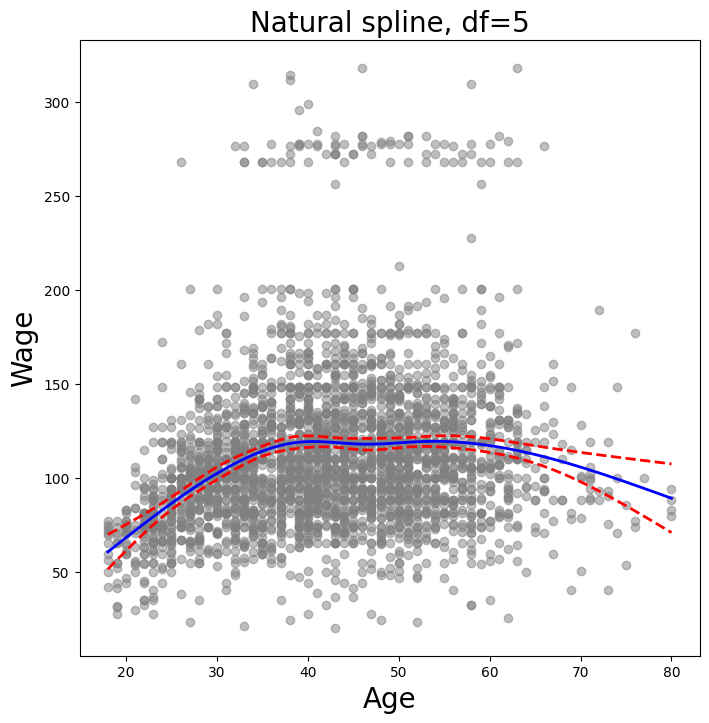

In [ ]:
plot_wage_fit(age_df,
ns_age,
'Natural spline, df=5');

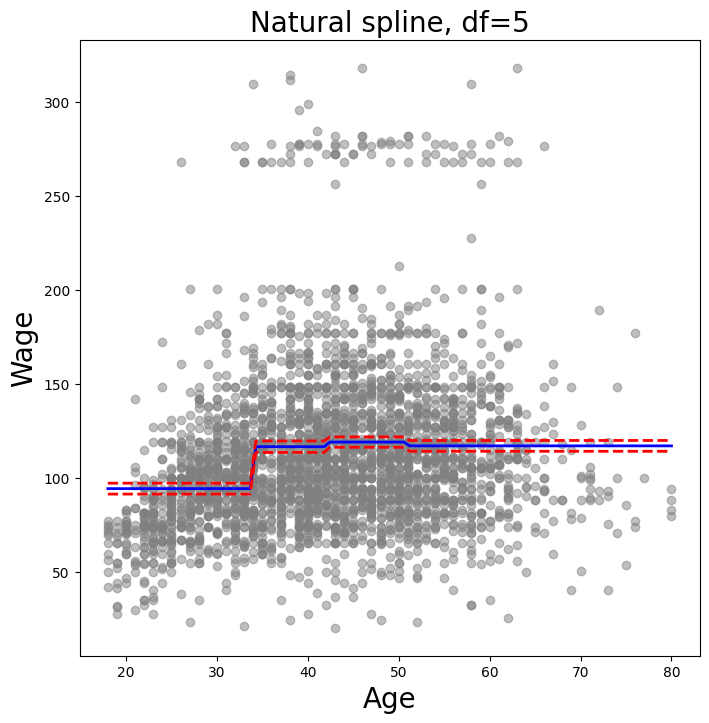

In [ ]:
plot_wage_fit(age_df,
bs_age0,
'Natural spline, df=5');

# GAM

In [39]:
wage = load_data("Wage")
age_grid = np.linspace(age.min(), age.max(), 100)
y = wage["wage"]
age = wage["age"]
high_earn = wage["high_earn"] = y < 250

In [12]:
X_age = np.asarray(age).reshape((-1,1))
gam = LinearGAM(s_gam(0, lam=0.6))
gam.fit(X_age, y)


LinearGAM(callbacks=[Deviance(), Diffs()], fit_intercept=True, 
   max_iter=100, scale=None, terms=s(0) + intercept, tol=0.0001, 
   verbose=False)

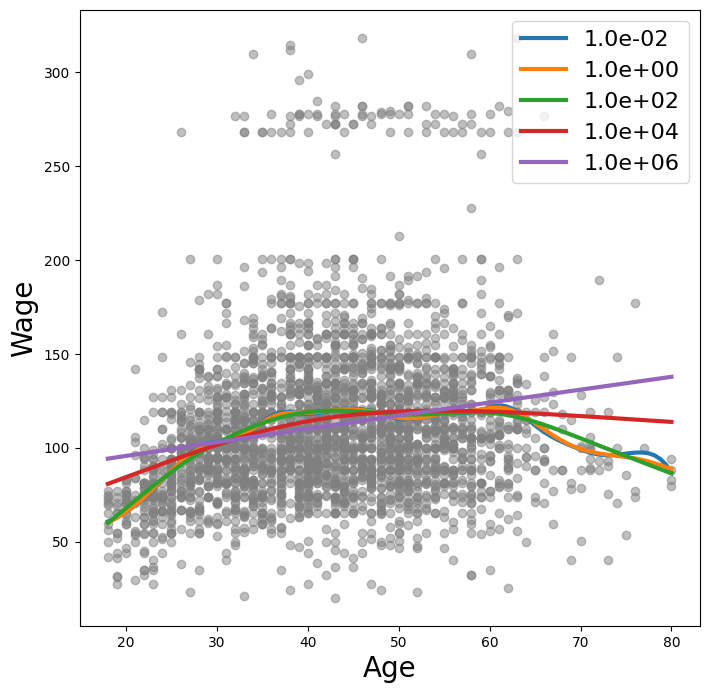

In [13]:
fig, ax = plt.subplots(figsize=(8, 8))
ax.scatter(age, y,
           facecolor="gray",
           alpha=.5)
for lam in np.logspace(-2, 6, 5):
  gam = LinearGAM(s_gam(0, lam=lam)).fit(X_age, y)
  ax.plot(age_grid,
          gam.predict(age_grid),
          label='{:.1e}'.format(lam),
          linewidth=3)
ax.set_xlabel("Age", fontsize=20)
ax.set_ylabel("Wage", fontsize=20)
ax.legend(fontsize=16)
plt.show()

Vamos a hacer la busqueda del parametro lambda mas optimo

100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


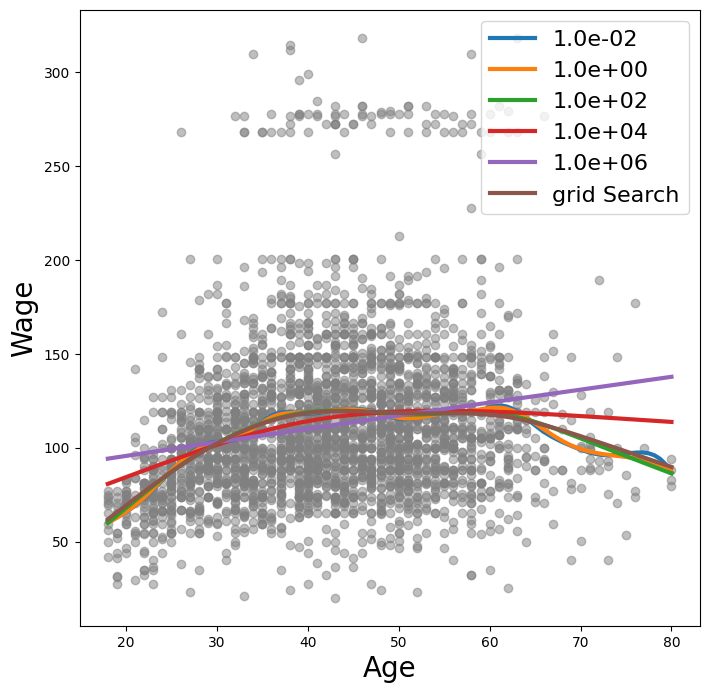

In [14]:
gam_opt = gam.gridsearch(X_age, y)
ax.plot(age_grid,
        gam_opt.predict(age_grid),
        label='grid Search',
        linewidth=3)
ax.legend(fontsize=16)
fig

vamos a ver la cantidad de grados de libertal del modelo

In [15]:
age_term = gam.terms[0]
lam_4 = approx_lam(X_age, age_term, 4)
age_term.lam = lam_4
degrees_of_freedom(X_age, age_term)

np.float64(4.000000100000307)

age_term es el objeto que representa el estado actua lde la cosas con respecto a ese spline

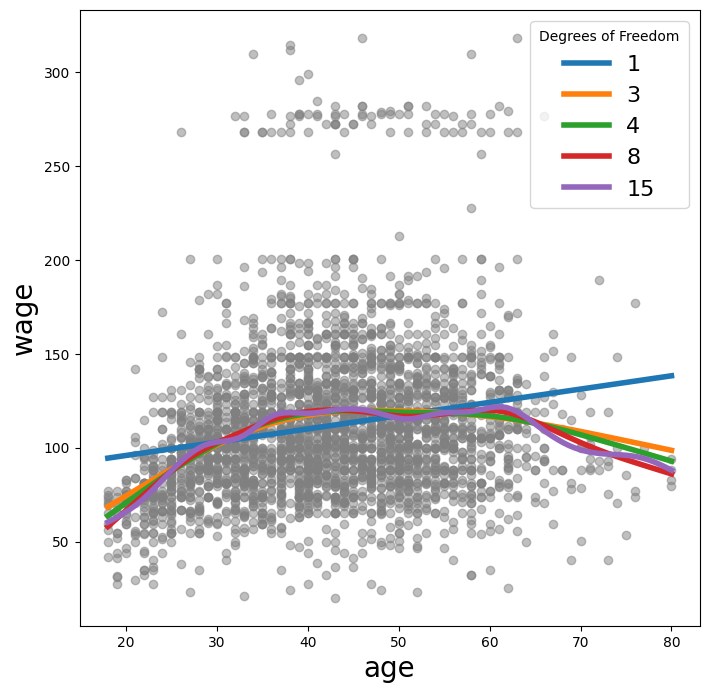

In [16]:
# ahora vamos a hacer una busqueda teniendo los valores de los df
fig, ax = plt.subplots(figsize=(8, 8))
ax.scatter(X_age,
        y,
        facecolor="gray",
        alpha=.5)
for df in [1, 3, 4, 8, 15]:
  lam = approx_lam(X_age, age_term, df + 1)
  age_term.lam = lam
  gam.fit(X_age, y)
  ax.plot(age_grid,
          gam.predict(age_grid),
          label="{:d}".format(df),
          linewidth=4)
ax.set_xlabel("age", fontsize=20)
ax.set_ylabel("wage", fontsize=20)
ax.legend(title="Degrees of Freedom", fontsize=16)
plt.show()

Ahora vamos a construir una GAM de forma manual teniendo en cuenta 3 variables:
- age NaturalSpline
- education StepFunction
- year Natural Spline

In [17]:
ns_age = NaturalSpline(df=4).fit(age)
ns_year = NaturalSpline(df=5).fit(wage["year"])
Xs = [ns_age.transform(age),
      ns_year.transform(wage["year"]),
      pd.get_dummies(wage["education"]).values]




In [18]:
X_bh = np.hstack(Xs)
gam_bh = sm.OLS(y, X_bh).fit()
summarize(gam_bh)

,coef,std err,t,P>|t|
x1,46.4460,3.732,12.446,0.000
x2,28.9349,3.884,7.449,0.000
x3,63.6722,9.231,6.898,0.000
x4,10.9669,7.650,1.434,0.152
x5,1.8374,3.177,0.578,0.563
x6,10.4409,3.790,2.755,0.006
x7,2.0020,3.399,0.589,0.556
x8,9.6055,4.053,2.370,0.018
x9,5.8989,2.419,2.438,0.015
x10,43.8013,4.383,9.993,0.000


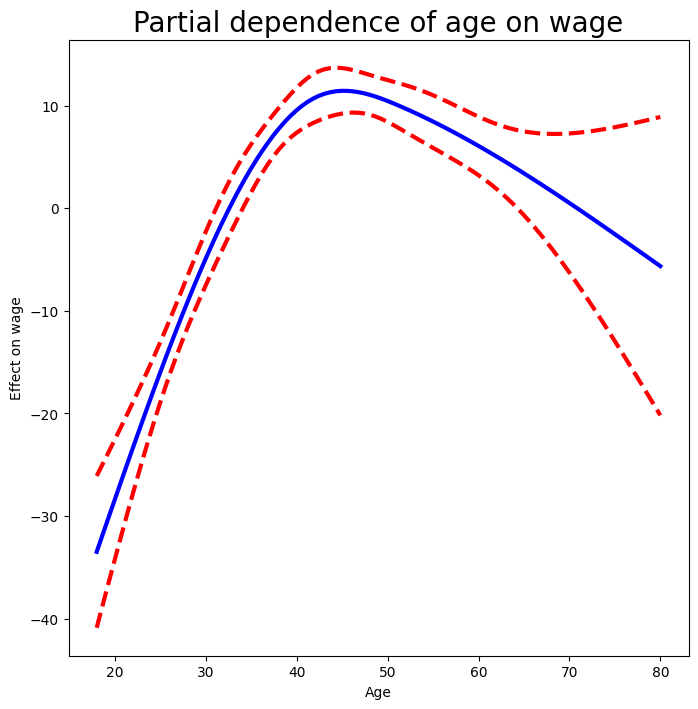

In [19]:
age_grid = np.linspace(age.min(),
                       age.max(),
                       100)
X_age_bh = X_bh.copy()[:100]
X_age_bh[:] = X_bh[:].mean(0)[None,:]
X_age_bh[:,:4] = ns_age.transform(age_grid)
preds = gam_bh.get_prediction(X_age_bh)
bounds_age = preds.conf_int(alpha=0.05)
partial_age = preds.predicted_mean
center = partial_age.mean()
partial_age -= center
bounds_age -= center
fig, ax = plt.subplots(figsize=(8,8))
ax.plot(age_grid, partial_age , 'b', linewidth=3)
ax.plot(age_grid, bounds_age[:,0], 'r--', linewidth=3)
ax.plot(age_grid, bounds_age[:,1], 'r--', linewidth=3)
ax.set_xlabel('Age')
ax.set_ylabel('Effect on wage')
ax.set_title('Partial dependence of age on wage', fontsize=20);

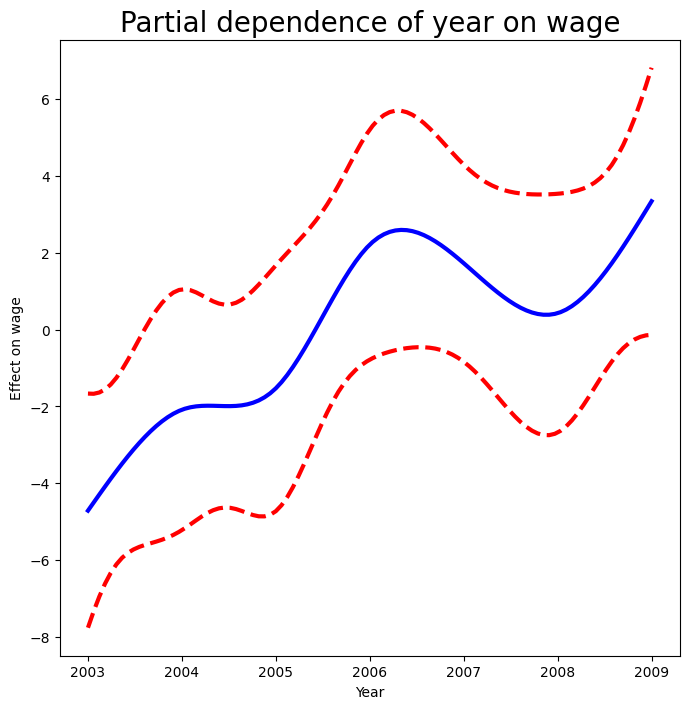

In [20]:
year_grid = np.linspace(2003, 2009, 100)
year_grid = np.linspace(wage['year'].min(),
                        wage['year'].max(),
                        100)
X_year_bh = X_bh.copy()[:100]
X_year_bh[:] = X_bh[:].mean(0)[None,:]
X_year_bh[:,4:9] = ns_year.transform(year_grid)

preds = gam_bh.get_prediction(X_year_bh)
bounds_year = preds.conf_int(alpha=0.05)

partial_year = preds.predicted_mean
center = partial_year.mean()
partial_year -= center
bounds_year -= center
fig, ax = plt.subplots(figsize=(8,8))
ax.plot(year_grid, partial_year , 'b', linewidth=3)
ax.plot(year_grid, bounds_year[:,0], 'r--', linewidth=3)
ax.plot(year_grid, bounds_year[:,1], 'r--', linewidth=3)
ax.set_xlabel('Year')
ax.set_ylabel('Effect on wage')
ax.set_title('Partial dependence of year on wage', fontsize=20);

Ahora veamos el caso de un Smoothing spline

In [21]:
gam_full = LinearGAM(s_gam(0, lam=0.6) +
                     s_gam(1, n_splines=7) +
                     f_gam(2, lam=0))
Xgam = np.column_stack([age,
                        wage["year"],
                        wage["education"].cat.codes])
gam_full = gam_full.fit(Xgam, y)

Text(0.5, 1.0, 'Partial dependence of age on wage - default lam=0.6')

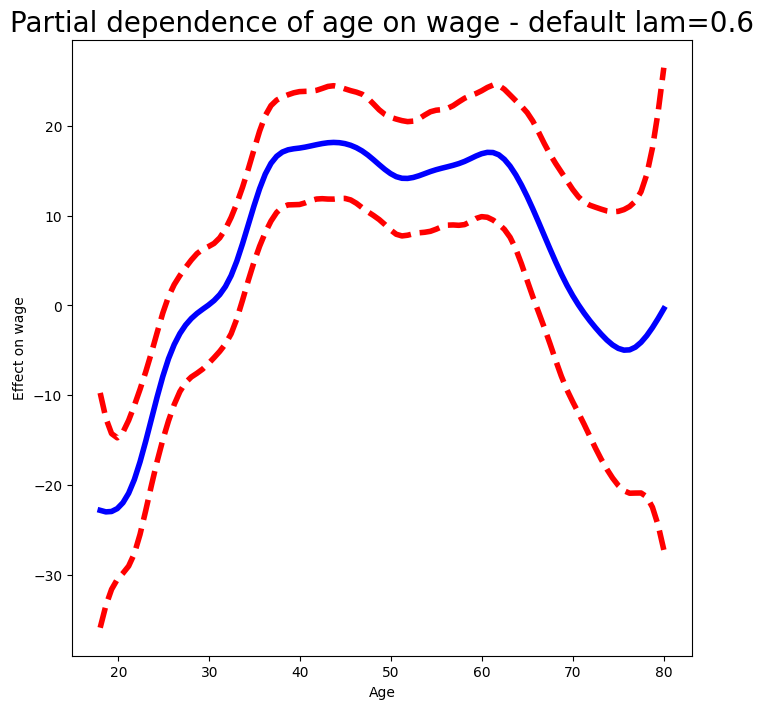

In [22]:
fig, ax = plt.subplots(figsize=(8,8))
plot_gam(gam_full, 0, ax=ax)
ax.set_xlabel('Age')
ax.set_ylabel('Effect on wage')
ax.set_title('Partial dependence of age on wage - default lam=0.6',
fontsize=20)

Podemos apreciar que el grafico es un tanto ondulante, esto es debido al valor de lambda seleccionado. haremos otro usando solo lo df explicitos

In [23]:
age_term = gam_full.terms[0]
age_term.lam = approx_lam(Xgam, age_term, df=4+1)
year_term = gam_full.terms[1]
year_term.lam = approx_lam(Xgam, year_term, df=4+1)
gam_full = gam_full.fit(Xgam, y)

Text(0.5, 1.0, 'Partial dependence of year on wage')

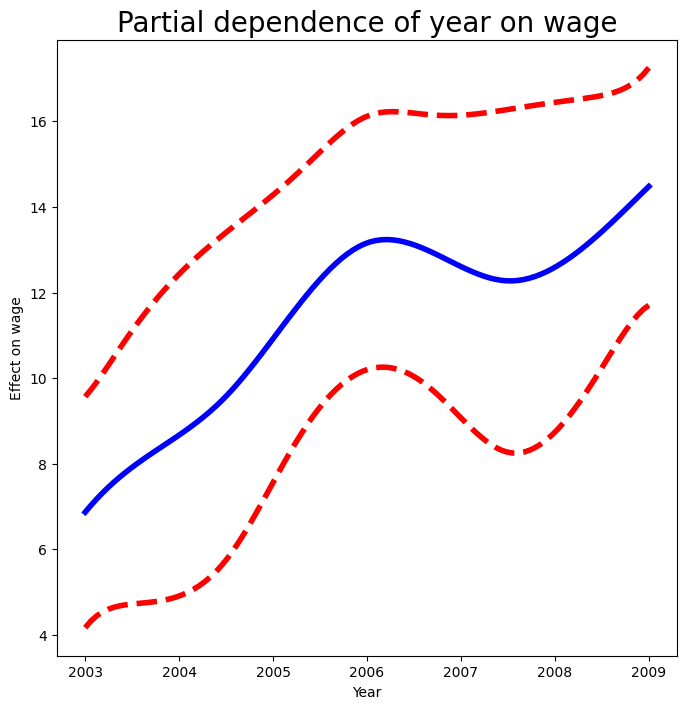

In [24]:
fig, ax = plt.subplots(figsize=(8,8))
plot_gam(gam_full,
         1,
         ax=ax)
ax.set_xlabel('Year')
ax.set_ylabel('Effect on wage')
ax.set_title('Partial dependence of year on wage', fontsize=20)

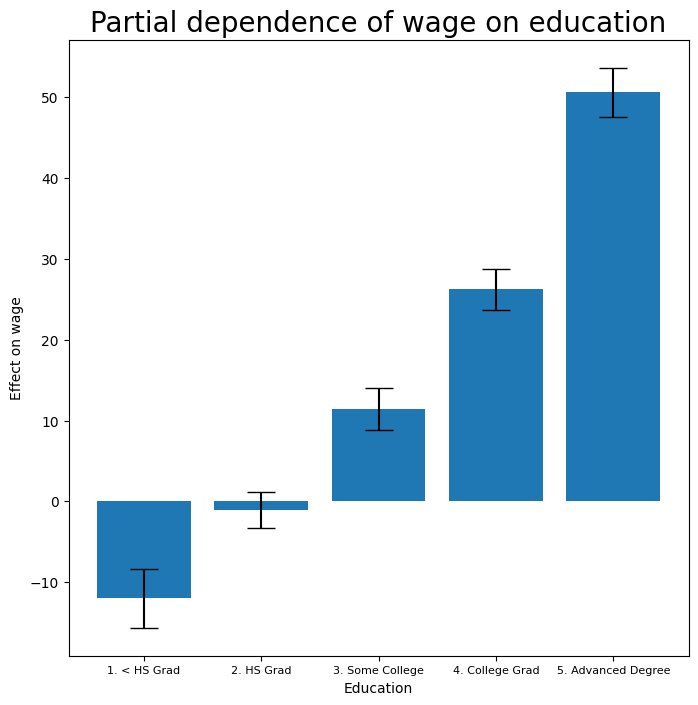

In [25]:
fig, ax = plt.subplots(figsize=(8, 8))
ax = plot_gam(gam_full, 2)
ax.set_xlabel('Education')
ax.set_ylabel('Effect on wage')
ax.set_title('Partial dependence of wage on education',
fontsize=20);
ax.set_xticklabels(wage['education'].cat.categories, fontsize=8);

# Anova tests for additive models

In [28]:
gam_0 = LinearGAM(age_term + f_gam(2, lam=0))
gam_0.fit(Xgam, y)
gam_linear = LinearGAM(age_term +
                       l_gam(1, lam=0)+
                       f_gam(2, lam=2))
gam_linear.fit(Xgam, y)

LinearGAM(callbacks=[Deviance(), Diffs()], fit_intercept=True, 
   max_iter=100, scale=None, terms=s(0) + l(1) + f(2) + intercept, 
   tol=0.0001, verbose=False)

In [30]:
# veamos el ANOVA
print(anova_gam(gam_0, gam_linear, gam_full))

        deviance           df  deviance_diff   df_diff         F    pvalue
0  105402.432206  2991.004005            NaN       NaN       NaN       NaN
1  105134.963388  2990.021391     267.468818  0.982614  7.741232  0.015868
2  105030.684668  2987.007254     104.278720  3.014137  0.983904  0.430903


In [31]:
gam_full.summary()

LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                     12.9927
Link Function:                     IdentityLink Log Likelihood:                                 -14930.261
Number of Samples:                         3000 AIC:                                            29888.5074
                                                AICc:                                            29888.648
                                                GCV:                                             1246.1129
                                                Scale:                                             35.1625
                                                Pseudo R-Squared:                                   0.2928
Feature Function                  Lam

/tmp/ipython-input-3870570873.py:1: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 

  gam_full.summary()


Hagamos algunas predicciones

In [33]:
Yhat = gam_full.predict(Xgam)
Yhat

array([ 52.3662492 ,  99.63834745, 111.7723448 , ...,  70.20962308,
        93.60649596, 104.91135937])

Ahora haremos una regresion logistica

In [40]:
gam_logit = LogisticGAM(age_term + l_gam(1, lam=0) +
                        f_gam(2,lam = 0))
gam_logit.fit(Xgam, high_earn)

LogisticGAM(callbacks=[Deviance(), Diffs(), Accuracy()], 
   fit_intercept=True, max_iter=100, 
   terms=s(0) + l(1) + f(2) + intercept, tol=0.0001, verbose=False)

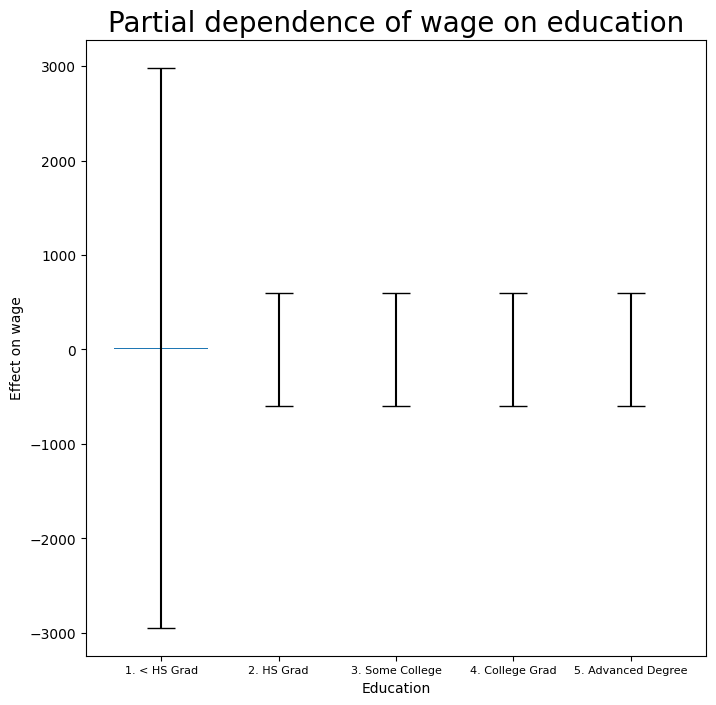

In [42]:
fig, ax = plt.subplots(figsize=(8, 8))
ax = plot_gam(gam_logit, 2)
ax.set_xlabel('Education')
ax.set_ylabel('Effect on wage')
ax.set_title('Partial dependence of wage on education',
fontsize=20);
ax.set_xticklabels(wage['education'].cat.categories, fontsize=8);

In [43]:
pd.crosstab(wage["high_earn"], wage["education"])

education,1. < HS Grad,2. HS Grad,3. Some College,4. College Grad,5. Advanced Degree
high_earn,,,,,
False,0,5,7,22,45
True,268,966,643,663,381


Como podemos apreciar en el grafico, para el modelo se le hajce complicado determinar si un persona con HS grad menor podria ser un high earner ya que ninguno de ellos en el data set es un high_earner. Para dar una grarica mas sensata vamos a eliminar esos datos que sean de esa categoria

In [63]:
only_hs = wage["education"] == "1. < HS Grad"
wage_ = wage[~only_hs]
Xgam_ = np.column_stack([wage_["age"],
                        wage_["year"],
                        wage_["education"].cat.codes-1])
high_earn = wage_["high_earn"]

In [64]:
gam_logit_ = LogisticGAM(age_term+
                         year_term+
                         f_gam(2, lam=0))
gam_logit_.fit(Xgam_, high_earn)

LogisticGAM(callbacks=[Deviance(), Diffs(), Accuracy()], 
   fit_intercept=True, max_iter=100, 
   terms=s(0) + s(1) + f(2) + intercept, tol=0.0001, verbose=False)

[Text(0, 0, '2. HS Grad'),
 Text(1, 0, '3. Some College'),
 Text(2, 0, '4. College Grad'),
 Text(3, 0, '5. Advanced Degree')]

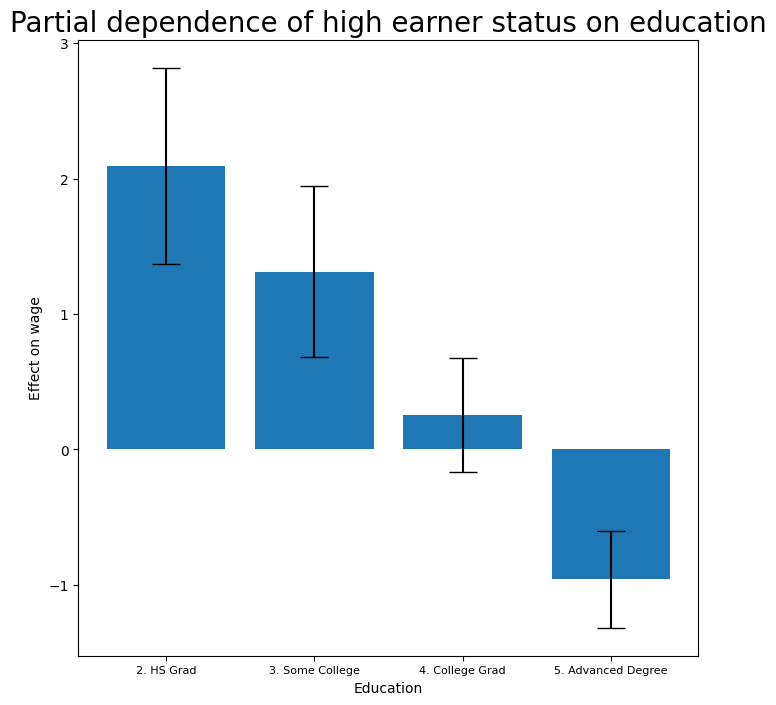

In [65]:
fig, ax = plt.subplots(figsize=(8, 8))
ax = plot_gam(gam_logit_, 2)
ax.set_xlabel('Education')
ax.set_ylabel('Effect on wage')
ax.set_title('Partial dependence of high earner status on education',
             fontsize=20);
ax.set_xticklabels(wage['education'].cat.categories[1:], fontsize=8)

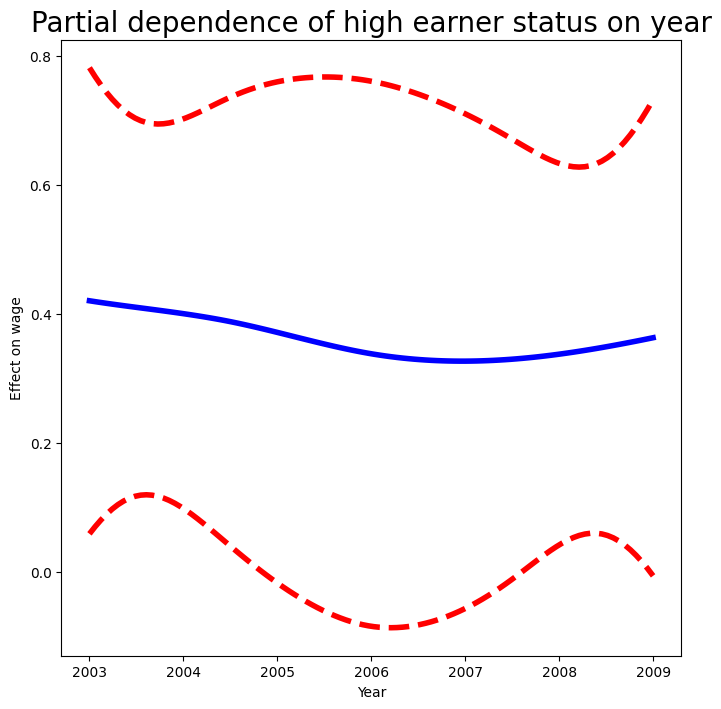

In [70]:
fig, ax = plt.subplots(figsize=(8, 8))
ax = plot_gam(gam_logit_, 1)
ax.set_xlabel('Year')
ax.set_ylabel('Effect on wage')
ax.set_title('Partial dependence of high earner status on year',
fontsize=20);

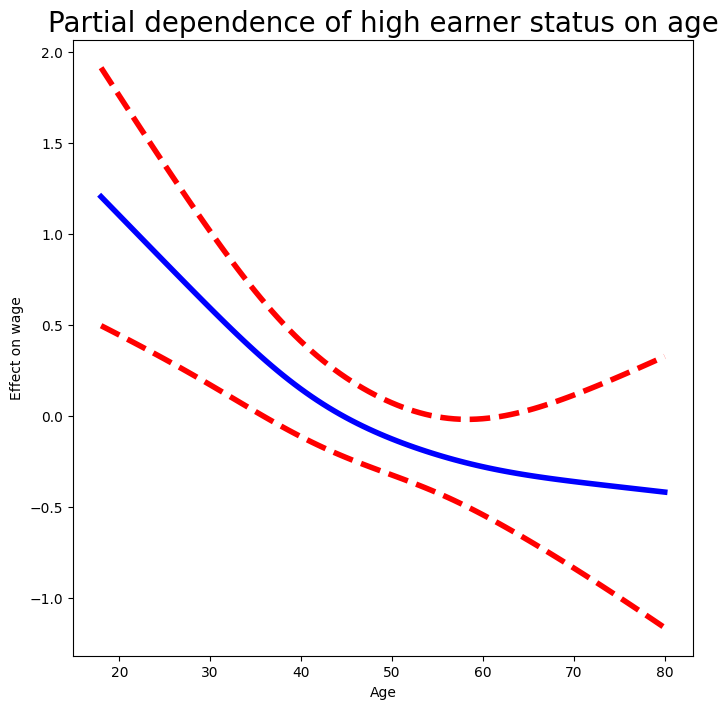

In [68]:
fig, ax = plt.subplots(figsize=(8, 8))
ax = plot_gam(gam_logit_, 0)
ax.set_xlabel('Age')
ax.set_ylabel('Effect on wage')
ax.set_title('Partial dependence of high earner status on age',
fontsize=20);

# Local Regression

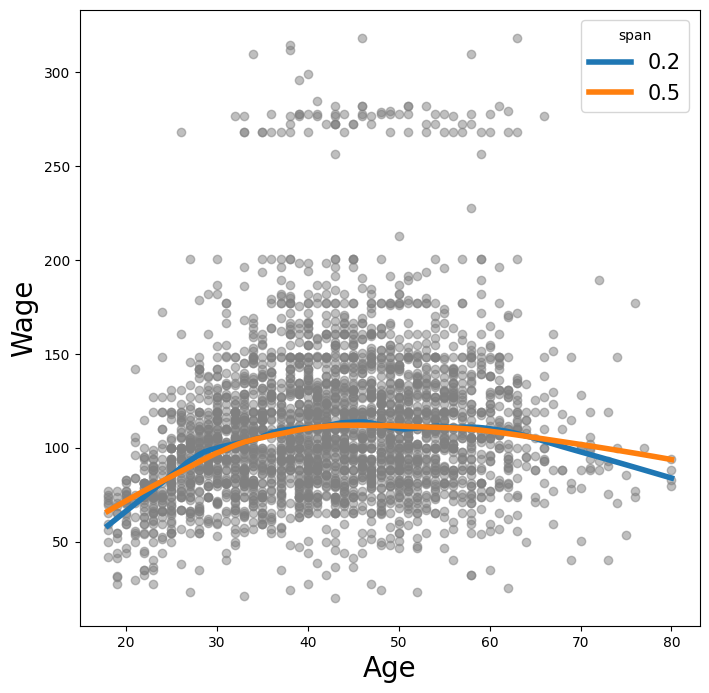

In [73]:
lowess = sm.nonparametric.lowess
fig, ax = plt.subplots(figsize=(8,8))
ax.scatter(age, y, facecolor='gray', alpha=0.5)
for span in [0.2, 0.5]:
  fitted = lowess(y,
                  age,
                  frac=span,
                  xvals=age_grid)
  ax.plot(age_grid,
          fitted,
          label='{:.1f}'.format(span),
          linewidth=4)
ax.set_xlabel('Age', fontsize=20)
ax.set_ylabel('Wage', fontsize=20);
ax.legend(title='span', fontsize=15);